# Import libraries

In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Load data

In [15]:
data_dir = Path("../../data/1000G")
chunks_root = os.path.join(data_dir, "chunks")
non_snp_cols = ['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE']
# We'll add the parsed population info, too:
derived_cols = ['population', 'subpopulation']
non_snp_cols_full = non_snp_cols + derived_cols

pc_range = [1, 5, 15, 35, 40, 50, 60, 100, 110, 130, 150, 170, 200]
max_nr_pcs = 200
pcs_df = pd.read_pickle(f"{data_dir}/pca/1000G_{max_nr_pcs}_PCs.pkl")


In [ ]:


def impute_inplace(A, fill_for_all_nan=0.0):
    # A is (N,M) float with NaNs
    col_means = np.nanmean(A, axis=0)
    col_means = np.where(np.isnan(col_means), fill_for_all_nan, col_means)
    r, c = np.where(np.isnan(A))
    if r.size:
        A[r, c] = col_means[c]

compare_pcs = pd.DataFrame()
for PC_nr in pc_range:
    print(PC_nr)
    PCS_cols = [f"PC{a+1}" for a in range(PC_nr)]
    pcs_temp = pcs_df[PCS_cols]

    # --- Build X as a NumPy array (N,p) with intercept ---
    X_pc = pcs_temp.to_numpy(dtype=np.float64)              # (N, PC_nr)
    X = np.concatenate([np.ones((X_pc.shape[0], 1)), X_pc], axis=1)  # (N, p=PC_nr+1)

    # Precompute P = (X'X)^(-1) X' using solve (avoids explicit inverse)
    XtX = X.T @ X                                           # (p,p)
    P = np.linalg.solve(XtX, X.T)                           # (p,N)

    F_chroms = []

    for chrom in sorted(os.listdir(chunks_root)):
        print(f"chrom = {chrom}")
        chrom_path = f"{chunks_root}/{chrom}"
        if not os.path.isdir(chrom_path):
            continue

        chunk_files = sorted(f for f in os.listdir(chrom_path) if f.endswith(".pkl"))
        if not chunk_files:
            continue

        F_chunks = []

        for fname in chunk_files:
            path_chunk = f"{chrom_path}/{fname}"
            df = pd.read_pickle(path_chunk)

            snp_cols = [c for c in df.columns if c not in non_snp_cols_full]
            if not snp_cols:
                continue

            # Genotype/het as NumPy
            G = df[snp_cols].to_numpy(dtype=np.float64)                  # (N,M)
            H = (df[snp_cols].to_numpy(dtype=np.float64) == 0.0).astype(np.float64)

            # --- Sanity check: row counts must match between PCs and genotypes
            if X.shape[0] != G.shape[0]:
                raise ValueError(f"Row mismatch: PCs N={X.shape[0]} vs genotypes N={G.shape[0]}")

            # Impute NaNs per column
            impute_inplace(G, fill_for_all_nan=0.0)
            impute_inplace(H, fill_for_all_nan=0.0)

            # Batched OLS predictions (all NumPy → no label alignment)
            BG = P @ G                  # (p,M)
            EG = X @ BG                 # (N,M)

            BH = P @ H                  # (p,M)
            EH = X @ BH                 # (N,M)

            # F-hat
            p_hat = np.clip((EG + 1.0) / 2.0, 1e-6, 1 - 1e-6)
            denom = np.clip(2.0 * p_hat * (1.0 - p_hat), 1e-6, None)
            F_hat = np.clip(1.0 - (EH / denom), 0.0, 1.0)                # (N,M)

            F_chunks.append(F_hat.mean(axis=1))                           # (N,)

        if F_chunks:
            F_mean_per_ind_chr = np.mean(np.column_stack(F_chunks), axis=1)
            F_chroms.append(F_mean_per_ind_chr)

    if F_chroms:
        F_mean_per_ind_per_chrom = np.mean(np.column_stack(F_chroms), axis=1)
    compare_pcs[f"{PC_nr}PCs"] = F_mean_per_ind_per_chrom

1
chrom = chrom_20
chrom = chrom_21
chrom = chrom_22


In [34]:
df = compare_pcs.copy()

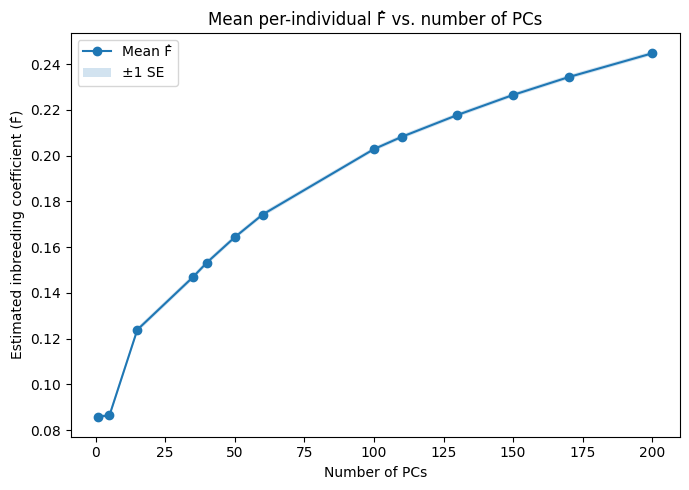

In [35]:
import matplotlib.pyplot as plt

mean_vals = df.mean(axis=0)   # mean per PC
std_vals  = df.std(axis=0)
se_vals   = std_vals / (df.shape[0] ** 0.5)

x = [int(col.replace("PCs","")) for col in df.columns]

plt.figure(figsize=(7,5))
plt.plot(x, mean_vals, marker="o", label="Mean F̂")
plt.fill_between(x, mean_vals - se_vals, mean_vals + se_vals, alpha=0.2, label="±1 SE")
plt.xlabel("Number of PCs")
plt.ylabel("Estimated inbreeding coefficient (F̂)")
plt.title("Mean per-individual F̂ vs. number of PCs")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_18921/343561853.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="PCs", y="F", data=df_long, inner="quartile", scale="width")


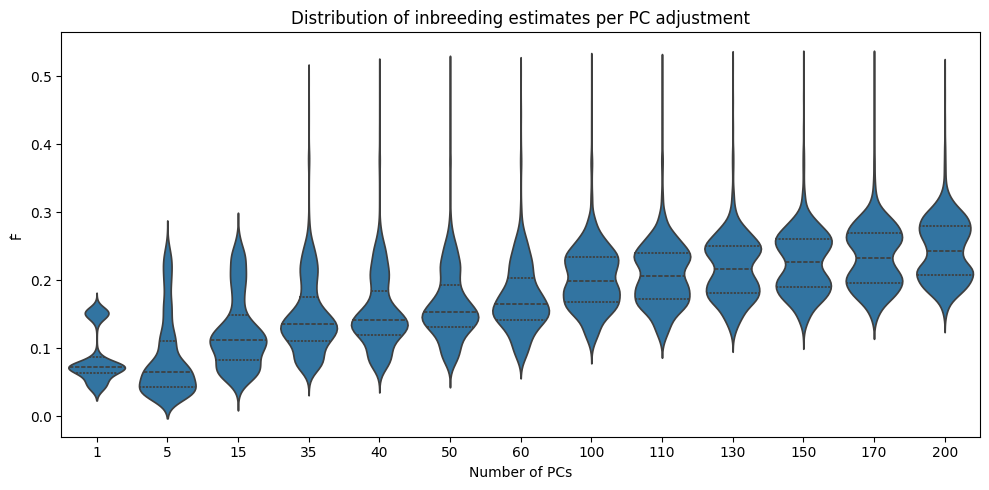

In [36]:
import seaborn as sns

df_long = df.melt(var_name="PCs", value_name="F")
df_long["PCs"] = df_long["PCs"].str.replace("PCs","").astype(int)

plt.figure(figsize=(10,5))
sns.violinplot(x="PCs", y="F", data=df_long, inner="quartile", scale="width")
plt.xlabel("Number of PCs")
plt.ylabel("F̂")
plt.title("Distribution of inbreeding estimates per PC adjustment")
plt.tight_layout()
plt.show()


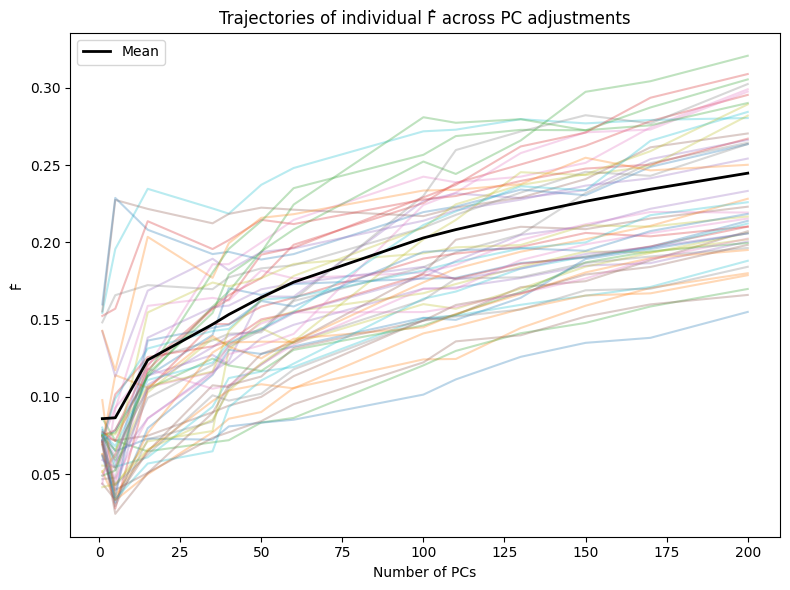

In [37]:
subset = df.sample(n=50, random_state=1)   # random subset of individuals
x = [int(c.replace("PCs","")) for c in df.columns]

plt.figure(figsize=(8,6))
for i, row in subset.iterrows():
    plt.plot(x, row.values, alpha=0.3)

plt.plot(x, df.mean(axis=0), color="black", linewidth=2, label="Mean")
plt.xlabel("Number of PCs")
plt.ylabel("F̂")
plt.title("Trajectories of individual F̂ across PC adjustments")
plt.legend()
plt.tight_layout()
plt.show()


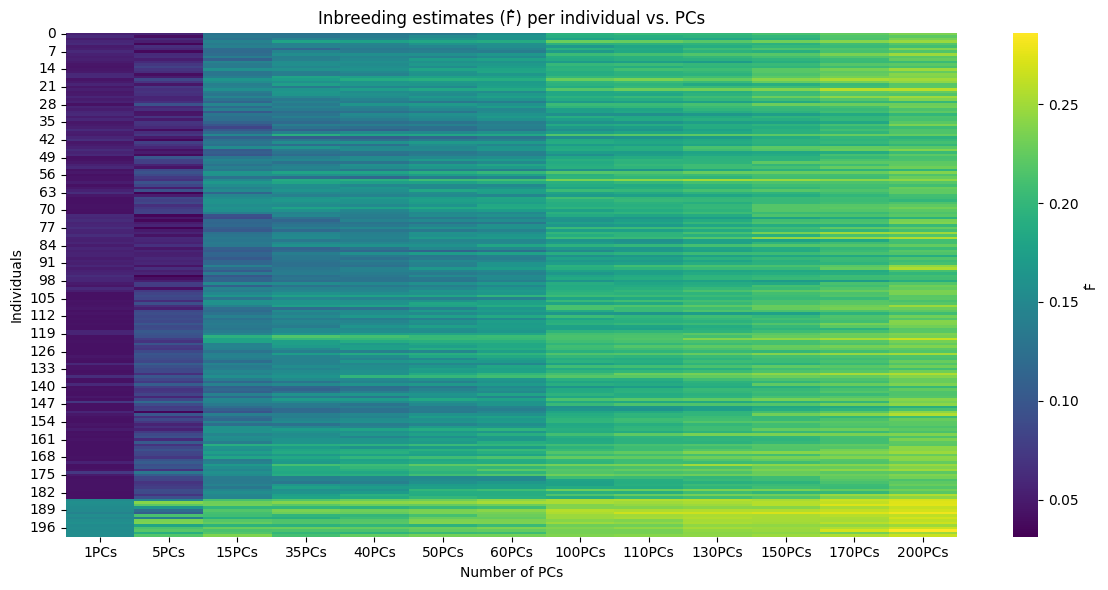

In [38]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.heatmap(df.iloc[:200], cmap="viridis", cbar_kws={'label': 'F̂'})  # first 200 individuals
plt.xlabel("Number of PCs")
plt.ylabel("Individuals")
plt.title("Inbreeding estimates (F̂) per individual vs. PCs")
plt.tight_layout()
plt.show()


In [3]:
pcs_df = pcs_df.drop(['FID'], axis=1)

In [7]:


# Fixed IID order for all chunks
iid_order = pcs_df.index.to_numpy()





        # Align to pcs order
        df = df.set_index(df['FID'].astype(str)).reindex(iid_order)

        # Extract genotype matrix (N,M)
        snp_cols = [c for c in df.columns if c not in non_snp_cols_full]
        if len(snp_cols) == 0:
            continue

        # Raw matrices for G and H (float; allow NaNs)
        G = df[snp_cols].to_numpy(dtype=np.float64)  # {-1,0,1} (with NaNs)
        H = (df[snp_cols].to_numpy() == 0).astype(np.float64)  # 1 if het (with NaNs where df had NaN)

        # --- Mean-impute per column, robust to all-NaN columns
        def impute_inplace(A, fill_for_all_nan=0.0):
            # column means with NaNs ignored
            col_means = np.nanmean(A, axis=0)
            # replace NaN means (i.e., all-NaN columns) with a safe fill
            col_means = np.where(np.isnan(col_means), fill_for_all_nan, col_means)
            # indices of NaNs
            r, c = np.where(np.isnan(A))
            if r.size:
                A[r, c] = col_means[c]

        impute_inplace(G, fill_for_all_nan=0.0)
        impute_inplace(H, fill_for_all_nan=0.0)

        # --- Batched OLS predictions
        # EG = X @ ((X'X)^-1 X' G) ; EH analogous
        BG = P @ G              # (p,M)
        EG = X @ BG             # (N,M)

        BH = P @ H              # (p,M)
        EH = X @ BH             # (N,M)

        # --- F-hat per SNP, then mean per individual
        p_hat = np.clip((EG + 1.0) / 2.0, 1e-6, 1 - 1e-6)
        denom = np.clip(2.0 * p_hat * (1.0 - p_hat), 1e-6, None)
        F_hat = np.clip(1.0 - (EH / denom), 0.0, 1.0)   # (N,M)

        F_chunks.append(F_hat.mean(axis=1))  # (N,)

    if F_chunks:
        F_mean_per_ind_chr = np.mean(np.column_stack(F_chunks), axis=1)  # (N,)
        F_chroms.append(F_mean_per_ind_chr)

# ---- Final aggregate across chromosomes
if F_chroms:
    F_mean_per_ind_per_chrom = np.mean(np.column_stack(F_chroms), axis=1)  # (N,)
    # Optional: wrap in a Series with IID index
    F_series = pd.Series(F_mean_per_ind_per_chrom, index=iid_order, name="F_hat")
else:
    F_series = pd.Series(dtype=float, name="F_hat")


TypeError: boolean value of NA is ambiguous

In [8]:
df

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs6053859_A,rs1434790_G,rs6055356_C,rs138610676_C,...,rs7550_C,rs12303_G,rs45448193_C,rs147394627_C,rs7345927_C,rs11699630_C,rs35639082_C,rs73159501_C,rs78696462_G,rs351881_C
FID,,,,,,,,,,,,,,,,,,,,,
0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2500,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2501,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [9]:
pcs_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200
0,-0.011583,0.027266,0.011960,0.017402,-0.002826,-0.001475,0.006970,0.001830,-0.024722,-0.003704,...,-0.019225,-0.005681,0.000046,0.006257,-0.015859,-0.008490,0.001968,0.004078,-0.006488,-0.006309
1,-0.011306,0.027269,0.011363,0.017042,-0.000256,0.000669,0.008793,-0.001357,-0.028089,-0.005712,...,-0.007352,0.033442,0.000644,0.013115,-0.000578,-0.002701,-0.008841,-0.009368,-0.004871,-0.008819
2,-0.011712,0.026766,0.011278,0.015904,0.001041,0.000059,0.013733,-0.002562,-0.025384,-0.011435,...,0.000627,0.012013,0.004639,0.001248,0.008512,-0.014604,0.002158,0.015738,-0.016714,0.007612
3,-0.011391,0.027713,0.012725,0.018854,-0.004196,-0.000372,0.005480,0.000936,0.007262,-0.005152,...,-0.017035,-0.012656,-0.007817,-0.007654,-0.000970,0.004135,0.001104,-0.009433,-0.000884,-0.009166
4,-0.011239,0.027027,0.011830,0.017332,0.001220,-0.003073,0.011868,0.001882,-0.030110,-0.009237,...,-0.005675,0.004731,-0.011821,-0.012825,0.005341,-0.007842,0.006539,-0.008706,-0.001713,-0.004402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,-0.010268,0.007140,-0.038670,-0.014234,-0.001880,0.001880,0.005208,-0.000677,0.023306,-0.107904,...,0.014568,0.005229,-0.013871,-0.010035,0.017747,-0.018003,-0.012556,0.017319,-0.010796,-0.013961
2500,-0.010860,0.007364,-0.038665,-0.013475,0.002868,0.004553,0.010134,0.002965,0.041227,-0.106298,...,-0.001268,0.010784,0.020312,-0.000547,0.006890,0.024476,-0.013241,-0.002346,-0.013162,-0.002303
2501,-0.010450,0.006945,-0.038490,-0.012896,0.004474,0.006116,0.008317,0.001911,0.038895,-0.101970,...,-0.010920,0.004001,0.000559,-0.005525,-0.001286,0.014387,-0.005896,-0.015316,0.018070,-0.015180
2502,-0.010772,0.006275,-0.038852,-0.013199,0.002469,0.006504,0.007908,-0.001294,0.037605,-0.103845,...,0.006565,-0.010706,0.001791,0.005323,-0.027016,0.014877,-0.010754,-0.012228,0.004326,-0.010356


In [27]:
path_1K = "../../data/1000G/"


pheno_saved = False

# Traverse chromosomes in a stable order
for chrom in sorted(os.listdir(chunks_root)):
    path_chrom = os.path.join(chunks_root, chrom)
    if not os.path.isdir(path_chrom):
        continue

    # All chunks for this chromosome (sorted for determinism)
    chunks = sorted(os.listdir(path_chrom))
    if not chunks:
        continue

    # --- 1) Load the very first chunk ONCE (first chrom, first chunk) to build pheno ---
    if not pheno_saved:
        first_path = os.path.join(path_chrom, chunks[0])
        first = pd.read_pickle(first_path)

        # Parse IID into (subpopulation, population) and insert next to IID
        split_cols = first['IID'].astype(str).str.split('_', n=1, expand=True)
        first['subpopulation'] = split_cols[0]
        first['population']    = split_cols[1] if split_cols.shape[1] > 1 else pd.NA

        # Build pheno with just the non-SNP columns (keep order, drop dups if any)
        # Some datasets name columns differently; select by intersection to be safe:
        keep_cols = [c for c in non_snp_cols_full if c in first.columns]
        pheno = first[keep_cols].drop_duplicates().reset_index(drop=True)
        # pheno.to_pickle(os.path.join(out_root, "pheno.pkl"))
        pheno_saved = True


    # --- 2) For every chunk (including the first), drop non-SNP columns and save SNP-only ---
    for chunk in chunks:
        path_chunk = os.path.join(path_chrom, chunk)
        try:
            df = pd.read_pickle(path_chunk)
        except Exception as e:
            print(f"Skipping {path_chunk} (read error: {e})")
            continue

        # If IID parsing wasn't done in this chunk, that's fine — we drop these anyway
        # Just drop any of the non-SNP columns that exist in this df:
        drop_cols = [c for c in non_snp_cols_full if c in df.columns]
        df_snp = df.drop(columns=drop_cols, errors='ignore')


In [28]:
pheno

,FID,IID,PAT,MAT,SEX,PHENOTYPE,population,subpopulation
0,HG00096,EUR_GBR,0,0,1,-9,GBR,EUR
1,HG00097,EUR_GBR,0,0,2,-9,GBR,EUR
2,HG00099,EUR_GBR,0,0,2,-9,GBR,EUR
3,HG00100,EUR_GBR,0,0,2,-9,GBR,EUR
4,HG00101,EUR_GBR,0,0,1,-9,GBR,EUR
...,...,...,...,...,...,...,...,...
2499,NA21137,SAS_GIH,0,0,2,-9,GIH,SAS
2500,NA21141,SAS_GIH,0,0,2,-9,GIH,SAS
2501,NA21142,SAS_GIH,0,0,2,-9,GIH,SAS
2502,NA21143,SAS_GIH,0,0,2,-9,GIH,SAS


In [29]:
df_snp

,rs2953108_C,rs200528186_G,rs372779614_T,rs377395690_C,rs2212121_C,rs528935526_G,rs201979747_G,rs200386828_T,rs201456653_G,rs200483765_T,...,rs2157711_G,rs12628091_T,rs73174424_C,rs79183605_G,rs12158487_C,rs6010067_G,rs4040034_A,rs9616827_A,rs2519461_G,rs375798137_G
0,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
1,0,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0,0,1
3,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,0,0,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2500,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2501,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
2502,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,1,1,1,1,1


In [37]:
# 1) Standardize once
scaler = StandardScaler(with_mean=True, with_std=True)
float_dtype=np.float32
randomized=True
seed=42
X_std = scaler.fit_transform(df_snp.astype(float_dtype, copy=False))

# 2) Fit PCA once up to the largest k
pca = PCA(
    n_components=2,
    svd_solver="randomized" if randomized else "full",
    random_state=seed
)
scores = pca.fit_transform(X_std)        # shape: (n_samples, n_max)


In [39]:

df = pd.DataFrame(scores[:, :2], columns=[f"PC{i}" for i in range(1, 2+1)])

In [44]:
df['pop'] = pheno['subpopulation']

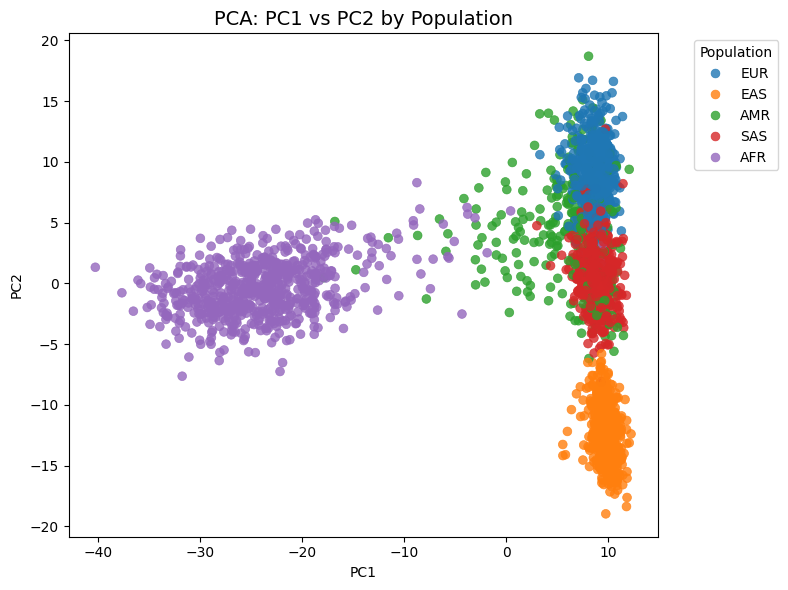

In [45]:
# assuming your dataframe is called df
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="PC1",
    y="PC2",
    hue="pop",
    s=40,           # point size
    alpha=0.8,      # transparency
    edgecolor=None  # cleaner look
)

plt.title("PCA: PC1 vs PC2 by Population", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Population", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()